In [1]:
import numpy as np
import math
from copy import deepcopy
import sklearn.datasets
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
X,y = sklearn.datasets.make_hastie_10_2()
X_train = X[0:8000,:]
y_train = y[0:8000]
X_test = X[8000:,:]
y_test = y[8000:]
print(X[0]) # 10 feature
print(y[0]) # target label

[ 0.21618419  0.0101298  -0.8835006   0.16568245  0.50030093 -1.10498159
 -1.0562681  -1.2326556   1.06041321 -0.82414437]
-1.0


# Exercise 1

1. Implement the AdaBoost ensemble algorithm by completing the following code:

In [3]:
class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X,y,sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X)

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X)

In [4]:
def compute_error(y_true, y_pred):
    return 0.5 - np.dot(y_true.T, y_pred) / (y_true.size * 2)

In [5]:
class AdaBoost: 
    def __init__(self, _weakModel, _T, k_step=10):
        self.T = _T
        self.weakModel = _weakModel
        self.alphas = []
        self.models = []
        self.errors = [] # ensamble error
        self.weight_error = []
        self.k_step = k_step


    def fit(self, X, y):
        # Distribuzione uniforme dei pesi associati agli esempi [1/|D|]
        w_start = 1 / len(X_train) # peso di un singolo esempio
        self.w = np.zeros(len(X_train)) 
        self.w.fill(w_start) # inseriemo i valori iniziali w_start
        
        partial_ensamble_pred = np.zeros(y.size) # errore dell'ensamble ad una determinata iterazione
        
        for t in range(0, self.T): # Itero T volte

            weakModelCopy = deepcopy(self.weakModel) # Mantengo i riferimenti del modello originale
            weakModelCopy.fit(X, y, self.w)  # Calcola m_t = A(D, w^t)

            # Somma dei pesi delle classificazioni errate (< 0.5 weakLearner)
            error = 0
            y_predict = weakModelCopy.predict(X)  
            for i in range(0, len(X)):
                if y_predict[i] != y[i]:
                    error += self.w[i]

            # Calcolo del peso associato alle ipotesi alpha_t = 1/2 ln ( [1-\epsilon] / [\epsilon] )
            alpha = 0.5 * math.log((1 - error) / error)

            # Aggiornamento dell'intero vettore pesi w in funzione di \alpha e della predizione (segno concorde o discorde)    
            sum = 0
            for i in range(0, len(X)):
                self.w[i] = self.w[i] * math.exp(-alpha * y[i] * y_predict[i])
                sum += self.w[i]

            #Normalizzazione dei pesi nell'intervallo [0, 1]
            for i in range(0, len(X)):
                self.w[i] = self.w[i] / sum
            
            # Calcolo M(x) = sign ( M_T-1(x) + alpha_t * m_t(x) )
            partial_ensamble_pred += np.dot(alpha, y_predict) # alpha_t * m_t(x)
            partial_ensemble_error = compute_error(y, np.sign(partial_ensamble_pred))
            
            self.errors.append(partial_ensemble_error)
            self.alphas.append(alpha)
            self.models.append(weakModelCopy)
            self.weight_error.append(error)
            
            if t % self.k_step == 0:
                print("{} \tWeight error: {} \t Ensamble error: {}".format(
                          t+1,
                          round(error,4),
                          round(partial_ensemble_error, 4)
                ))
            
        return self

    def predict(self, X):
        preds = np.zeros(X.shape[0])

        for t in range(0, self.T):
            a = self.alphas[t]
            m = self.models[t]

            # Peso tutte le predizioni del modello m con alpha e le sommo a tutte le preds già ottenute
            preds += np.dot(a, m.predict(X))
        return np.sign(preds)

In the implementation you are free to assume:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $|y|$.

2. Test your implementation on the dataset loaded above and using an SVC with a polynomial kernel. 

In [6]:
weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 100) # 100 iterazioni
adaboost.fit(X_train, y_train)

1 	Weight error: 0.3554 	 Ensamble error: 0.3554
11 	Weight error: 0.3836 	 Ensamble error: 0.2205
21 	Weight error: 0.4146 	 Ensamble error: 0.1764
31 	Weight error: 0.4218 	 Ensamble error: 0.1626
41 	Weight error: 0.4269 	 Ensamble error: 0.1504
51 	Weight error: 0.4462 	 Ensamble error: 0.1417
61 	Weight error: 0.453 	 Ensamble error: 0.1371
71 	Weight error: 0.4618 	 Ensamble error: 0.1342
81 	Weight error: 0.448 	 Ensamble error: 0.1286
91 	Weight error: 0.4639 	 Ensamble error: 0.1255


In [7]:
y_train_pred = adaboost.predict(X_train)
y_test_pred = adaboost.predict(X_test)

print("Accuratezza training set: %s" % accuracy_score(y_train, y_train_pred))
print("Accuratezza test set: %s" % accuracy_score(y_test, y_test_pred))

Accuratezza training set: 0.875875
Accuratezza test set: 0.85175


3. evaluate the AdaBoost performances as usual by calculating the classification error and compare it with the classification error of the weak model.


In [8]:
print("Training Set\n")
print("Accuracy \t Error")
print("%5f \t %5f\n" % (accuracy_score(y_train, y_train_pred), compute_error(y_train, y_train_pred)))
print("-" * 30)
print("Test Set\n")
print("Accuracy \t Error")
print("%5f \t %5f\n" % (accuracy_score(y_test, y_test_pred), compute_error(y_test, y_test_pred)))

Training Set

Accuracy 	 Error
0.875875 	 0.124125

------------------------------
Test Set

Accuracy 	 Error
0.851750 	 0.148250



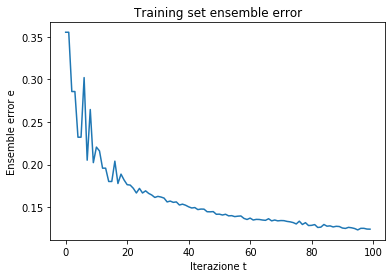

In [9]:
xs = np.arange(0, len(adaboost.errors))
plt.plot(xs, adaboost.errors)
plt.xlabel("Iterazione t")
plt.ylabel("Ensemble error e")
plt.title("Training set ensemble error")
plt.show()

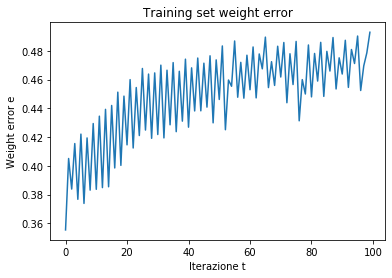

In [10]:
xs = np.arange(0, len(adaboost.weight_error))
plt.plot(xs, adaboost.weight_error)
plt.xlabel("Iterazione t")
plt.ylabel("Weight error e")
plt.title("Training set weight error")
plt.show()

In [11]:
svc = SVC(kernel="poly", degree=3).fit(X_train, y_train)

In [12]:
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print("Training Set\n")
print("Accuracy \t Error")
print("%5f \t %5f\n" % (accuracy_score(y_train, y_train_pred), compute_error(y_train, y_train_pred)))
print("-" * 30)
print("Test Set\n")
print("Accuracy \t Error")
print("%5f \t %5f\n" % (accuracy_score(y_test, y_test_pred), compute_error(y_test, y_test_pred)))

Training Set

Accuracy 	 Error
0.644625 	 0.355375

------------------------------
Test Set

Accuracy 	 Error
0.611000 	 0.389000



**Note 1**:  
since the labels are bound to be in ${+1, -1}$, the classification error (i.e., the number of incorrectly classified examples over the total number of examples) can be easily computed as:
$$
   error(y,y') = \frac{N - y \cdot y'}{2N} = \frac{1}{2} - \frac{y \cdot y'}{2N},
$$
where $N$ is the total number of examples. The formula can be derived noticing that $y \cdot y'$ calculates the number $N_c$ of examples correctly classified  minus the number $N_{\bar c}$ of examples incorrectly classified. We have then $y \cdot y' = N_c - N_{\bar c}$ and by noticing that $N = N_c + N_{\bar c}$:
$$
   N - y \cdot y' = N_c + N_{\bar c} - N_c + N_{\bar c} = 2 N_{\bar c} \Rightarrow \frac{N - y \cdot y'}{2 N} = \frac{N_{\bar c}}{N}
$$

**Note 2**:
do not forget to deepcopy your base model before fitting it to the new data

**Note 3**:
The SVC model allows specifying weights, but it *does not* work well when weights are normalized (it works well when the weights are larger). The following class takes normalized weights and denormalize them before passing them to the SVC classifier:

```python
    class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X,y,sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X)

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X)
```

# Exercise 2

1. Write a weak learner to be used with the AdaBoost algorithm you just wrote. The weak learner that you will implement is the most inaccurate weak learner possible: it basically works by extracting a linear model at random and trying to use that model to classify the examples. Being extracted at random the models it generates do not guarantee that the weighted error $\epsilon_t$ is smaller than $0.5$. The algorithm solves this problem by flipping the decisions whenever it finds out that $\epsilon_t > 0.5$ (i.e., if the weighted error is larger than $0.5$ it reverses the sign of all the weights so that the decision surface stays the same, but the regions where it predicts $+1$ and $-1$ are reversed).

    It shall work as follows:

    - it creates a random linear model by generating the needed weight vector $\mathbf{w}$ at random (**note**: these are the weights of the linear model, they are *NOT* related in any way to the weights of the examples); each weight shall be sampled from U(-1,1);
    - it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$;
    - at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$; it predicts -1 otherwise.

In [13]:
class RandomLinearModel:
    # Peso totale degli elementi classificati in maniera errata
    def weighted_loss(self, y, y_pred, w):
        # True.astype(int) = 1
        # False.astype(int) = 0
        error = np.dot(w, ((y * y_pred) < 0).astype(int)) # w_i * [y_i != m_t(xi)] = 1 
        return error
        
    def fit(self, X, y, example_weights):
        # w_ composto da 10 coefficienti
        self.lin_model_w = np.random.uniform(-1, 1, X.shape[1]) # Genero il weight vector con pesi U(-1,1);
        err = self.weighted_loss(y, self.predict(X), example_weights)
        # print(err)
        # flip
        if err > 0.5:
            self.lin_model_w * -1
        return self
        
    def predict(self, X):
        return np.sign(np.dot(X, self.lin_model_w))

2. Learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble (you are free to choose $K$ so to make your output just frequent enough to let you know what is happening but without flooding the console with messages). Evaluate the training and test error of the final ensemble model.

In [14]:
rs = RandomLinearModel()
ada = AdaBoost(rs, 5000, k_step=300).fit(X_train,y_train)

1 	Weight error: 0.499 	 Ensamble error: 0.499
301 	Weight error: 0.4992 	 Ensamble error: 0.452
601 	Weight error: 0.5015 	 Ensamble error: 0.4175
901 	Weight error: 0.5019 	 Ensamble error: 0.4071
1201 	Weight error: 0.4982 	 Ensamble error: 0.3906
1501 	Weight error: 0.5041 	 Ensamble error: 0.3778
1801 	Weight error: 0.5004 	 Ensamble error: 0.369
2101 	Weight error: 0.4989 	 Ensamble error: 0.3592
2401 	Weight error: 0.5025 	 Ensamble error: 0.3501
2701 	Weight error: 0.5015 	 Ensamble error: 0.3422
3001 	Weight error: 0.5005 	 Ensamble error: 0.3312
3301 	Weight error: 0.5055 	 Ensamble error: 0.3228
3601 	Weight error: 0.4971 	 Ensamble error: 0.316
3901 	Weight error: 0.502 	 Ensamble error: 0.3096
4201 	Weight error: 0.5008 	 Ensamble error: 0.3011
4501 	Weight error: 0.4975 	 Ensamble error: 0.2928
4801 	Weight error: 0.5064 	 Ensamble error: 0.2908


Training Set

Accuracy 	 Error
0.714625 	 0.285375

------------------------------
Test Set

Accuracy 	 Error
0.513250 	 0.486750



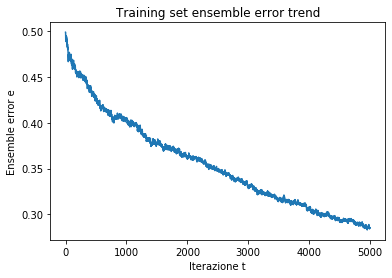

In [15]:
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

print("Training Set\n")
print("Accuracy \t Error")
print("%5f \t %5f\n" % (accuracy_score(y_train, y_train_pred), compute_error(y_train, y_train_pred)))
print("-" * 30)
print("Test Set\n")
print("Accuracy \t Error")
print("%5f \t %5f\n" % (accuracy_score(y_test, y_test_pred), compute_error(y_test, y_test_pred)))

xs = np.arange(0, len(ada.errors))
plt.plot(xs, ada.errors)
plt.xlabel("Iterazione t")
plt.ylabel("Ensemble error e")
plt.title("Training set ensemble error trend")
plt.show()

3. Write few paragraphs about what you think about the experiment and about the results you obtained.

Possiamo notare come, rispetto all'utilizzo del weakLearner SVC, Adaboost con il RandomLinearModel impieghi molte più iterazioni per ottenere una buona accuratezza sul training set. Questo è molto probabilmente dovuto all'utilizzo di modelli lineari inageguati che tendenzialmente commentono un errore che si aggira intorno al 50% degli esempi.

In generale Adaboost fa quindi molta fatica ad ottenere una buona accuratezza sul test set (non riesce dunque a generalizzare adeguatamente)